In [20]:
from classes.basic_optical_gating import BasicOpticalGating as BOG
from classes.basic_optical_gating import AdaptedV as BOGV
from classes.plotter import BasicOpticalGatingPlotter as BOGP
from classes.drawer import Drawer

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tf

In [34]:
# SECTION: Helper functions
def v_fitting(y_1, y_2, y_3, x_1, x_2, x_3):
    """
    Fit using a symmetric 'V' function, to find the interpolated minimum for three datapoints y_1, y_2, y_3,
    which are considered to be at coordinates x_1, x_2, x_3

    Args:
        y_1 (float): left y-coordinate
        y_2 (float): middle y-coordinate
        y_3 (float): right y-coordinate
        x_1 (float): left x-coordinate
        x_2 (float): middle x-coordinate
        x_3 (float): right x-coordinate

    Returns:
        tuple: m_1_l, m_3_l, c_1_l, c_3_l, m_3_r, m_1_r, c_1_r, c_3_r, x_l, y_l, x_r, y_r
    """    
    # Fit using a symmetric 'V' function, to find the interpolated minimum for three datapoints y_1, y_2, y_3,
    # which are considered to be at coordinates x_1, x_2, x_3
    
    # Calculate the gradients of our two lines
    m_1 = (y_2 - y_1) / (x_2 - x_1)
    m_3 = (y_2 - y_3) / (x_2 - x_3)

    # Line 1
    m_3_l = - m_1
    m_1_l = m_1
    c_1_l = y_1 - m_1_l * x_1
    c_3_l = y_3 - m_3_l * x_3

    x_l = (c_3_l - c_1_l) / (m_1_l - m_3_l)
    y_l = m_1_l * x_l + c_1_l

    # Line 2
    m_1_r = - m_3
    m_3_r = m_3
    c_1_r = y_1 - m_1_r * x_1
    c_3_r = y_3 - m_3_r * x_3


    x_r = (c_3_r - c_1_r) / (m_1_r - m_3_r)
    y_r = m_1_r * x_r + c_1_r

    return m_1_l, m_3_l, c_1_l, c_3_l, m_3_r, m_1_r, c_1_r, c_3_r

def v_fitting_standard(y_1, y_2, y_3):
    # Fit using a symmetric 'V' function, to find the interpolated minimum for three datapoints y_1, y_2, y_3,
    # which are considered to be at coordinates x=-1, x=0 and x=+1
    if y_1 > y_3:
        x = 0.5 * (y_1 - y_3) / (y_1 - y_2)
        y = y_2 - x * (y_1 - y_2)
    else:
        x = 0.5 * (y_1 - y_3) / (y_3 - y_2)
        y = y_2 + x * (y_3 - y_2)

    return x, y

In [68]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.use('pgf')
matplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)
matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (4.01407, 3.09654)

In [23]:
sequence = "D:/Downloads/Archive/seq.tif"
reference_sequence = "D:/Downloads/Archive/ref_seq.tif"
reference_sequence_period = "D:/Downloads/Archive/ref_seq.txt"

og = BOG()
og.logger.set_quiet()
og.set_sequence(sequence)
og.set_reference_sequence(reference_sequence)
og.set_reference_period(reference_sequence_period)
og.run()

(array([  49,  163,  419,  647,  761,  962, 1562, 1851, 2165], dtype=int64),)


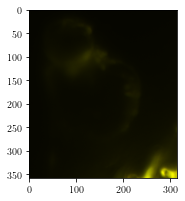

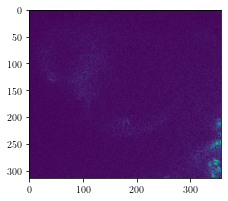

In [24]:
print(np.where((og.phases > 4.4) * (og.phases < 4.5)))

tf.imwrite("test.tif", np.array([og.sequence[49], og.sequence[163], np.zeros_like(og.sequence[0])]))

plt.imshow(np.array([og.sequence[49] / np.max(og.sequence[49]), og.sequence[163] / np.max(og.sequence[163]), np.zeros_like(og.sequence[0])]).T)
plt.show()

plt.imshow(np.abs(og.sequence[49].astype(np.int32) - og.sequence[163].astype(np.int32)))
plt.show()

In [25]:
sequence = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/brightfield/*tif"
reference_sequence = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/ref_seq.tif"
reference_sequence_period = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/ref_seq.txt"

og = BOG()
og.logger.set_quiet()
og.set_sequence(sequence)
og.set_reference_sequence(reference_sequence)
og.set_reference_period(reference_sequence_period)
og.run()

ogv = BOGV()
ogv.set_sequence(sequence)
ogv.set_reference_sequence(reference_sequence)
ogv.set_reference_period(reference_sequence_period)
ogv.run()

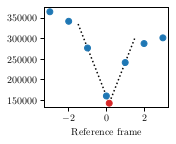

In [74]:
frame = 60
matplotlib.rcParams['figure.figsize'] = (2.5407, 2.09654)
plt.plot(og.sads[frame])
plt.xlabel("Reference frame")
plt.ylabel("SAD")
plt.tight_layout()
plt.savefig("SAD.pgf")
#plt.show()

min = np.argmin(og.sads[frame][2:-2]) + 2
xs = np.linspace(-3, 3, 7, )
plt.cla()
plt.scatter(xs, og.sads[frame][min - 3:min + 4], zorder = 100000)
y_1 = og.sads[frame][min - 1]
y_2 = og.sads[frame][min]
y_3 = og.sads[frame][min + 1]
x_1 = -1
x_2 = 0
x_3 = 1
m_1_l, m_3_l, c_1_l, c_3_l, m_3_r, m_1_r, c_1_r, c_3_r = v_fitting(y_1, y_2, y_3, x_1, x_2, x_3)
minima, y = v_fitting_standard(y_1, y_2, y_3)

def v_l(x,m,c,minima):
    return np.abs(m * x[x<minima] + c)

def v_r(x,m,c,minima):
    return m * x[x>minima] + c


xs = np.linspace(-1.5, 1.5, 100)
plt.plot(xs[xs<minima], v_l(xs, m_1_l, c_1_l, minima), ls = ":", c = "black")
xs = np.linspace(-1.5, 1.5, 100)
plt.plot(xs[xs>minima], v_r(xs, m_3_l, c_3_l, minima), ls = ":", c = "black")
plt.scatter([minima],[y], zorder = 100000, c = "tab:red")
plt.xlabel("Reference frame")
#plt.ylabel("Sum-of-absolute differences")
#plt.show()
plt.tight_layout()
plt.savefig("SAD_min.pgf")

In [7]:

#plt.savefig("experimental_bias.pgf")

In [8]:
plt.cla()
plt.scatter(og.phases[0:-1], og.delta_phases, s = 3)
plt.axhline(1, lw = 1, ls = ":", c = "black")
plt.xlabel("Estimated frame")
plt.ylabel("Delta frame")
plt.tight_layout()
plt.savefig("experimental_bias.pdf", backend = "pgf")

In [9]:
v = Drawer(30, 39.1, (256, 256))
v.generate_reference_sequence()
v.generate_sequence()

In [10]:
sog = BOG()
sog.settings["drift_correction"] = False
sog.set_reference_period(v.reference_period)
sog.set_reference_sequence(v.reference_sequence)
sog.set_sequence(v.sequence)
sog.run()

sogv = BOGV()
sog.settings["drift_correction"] = False
sogv.set_reference_period(v.reference_period)
sogv.set_reference_sequence(v.reference_sequence)
sogv.set_sequence(v.sequence)
sogv.run()

BOG ⚠ Minima for frame(s) [224, 615, 1006] outside of the valid range.


In [11]:
plt.cla()
plt.scatter(sog.phases[0:-1], sog.delta_phases, s = 3)
plt.scatter(sogv.phases[0:-1], sogv.delta_phases, s = 3)
plt.axhline(1, lw = 1, ls = ":", c = "black")
plt.xlabel("Estimated frame")
plt.ylabel("Delta frame")
plt.tight_layout()
plt.savefig("bias_correction.pdf", backend = "pgf")